In [6]:
from src.helpers import setup_env, compute_mean_and_std, plot_confusion_matrix
from src.data import get_data_loaders, visualize_one_batch
from src.train import optimize, one_epoch_test
from src.optimization import get_optimizer, get_loss
from src.predictor import Predictor, predictor_test
from src.model import CNNet
from src.lrfinder import lr_finder
import matplotlib.pyplot as plt
import multiprocessing
import torch
import torch.optim as optim
import numpy as np

In [7]:
# check if CUDA is available
train_on_gpu = torch.cuda.is_available()
workers = multiprocessing.cpu_count()

if not train_on_gpu:
    print('CUDA is not available.  Training on CPU ...')
else:
    print('CUDA is available!  Training on GPU ...')
    torch.cuda.empty_cache()
    print(f'Memory allocated: {torch.cuda.memory_allocated()}')
    print(f'Max memory allocated: {torch.cuda.max_memory_allocated()}')

# If running locally, this will download dataset
setup_env()

CUDA is available!  Training on GPU ...
Memory allocated: 252063744
Max memory allocated: 252063744
GPU available
Dataset already downloaded. If you need to re-download, please delete the directory c:\Users\justhess\OneDrive - Agilent Technologies\Documents\Python\ML stuff\Udacity projects\proj2\data\landmark_images
Reusing cached mean and std


Load Data Loaders and Visualize a Batch of Training Data

In [8]:
batchSize = 64        # size of the minibatch for stochastic gradient descent (or Adam)
validSize = 0.2       # fraction of the training data to reserve for validation
workers = 4

Reusing cached mean and std
Dataset mean: tensor([0.4638, 0.4725, 0.4687]), std: tensor([0.2697, 0.2706, 0.3017])
Reusing cached mean and std


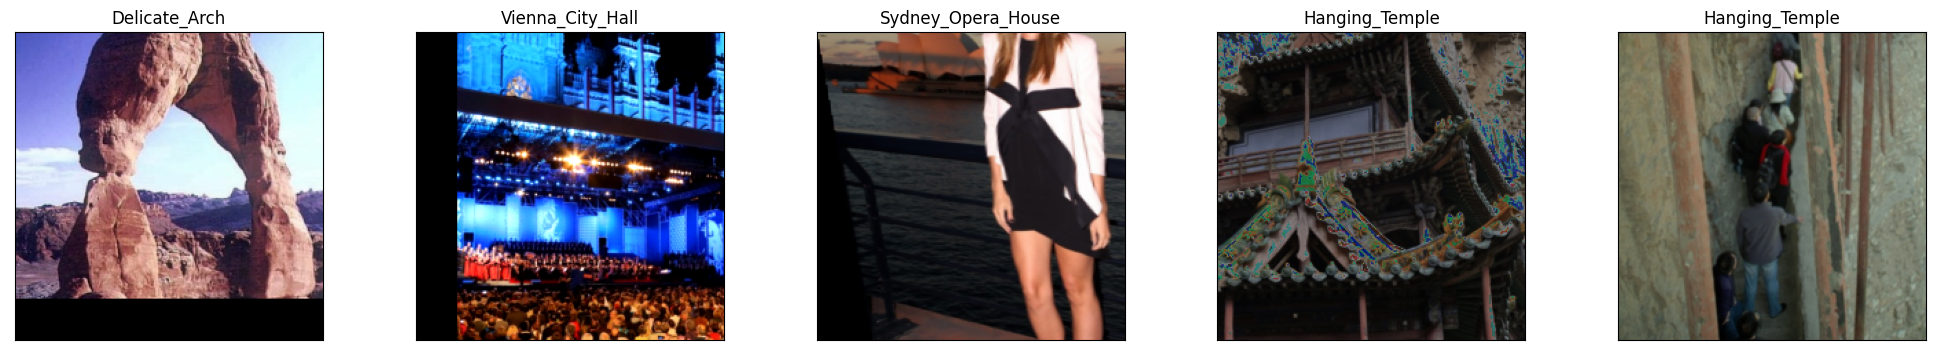

In [9]:
# NOTE: setting num_workers > 1 will slow down loading data loaders, but it will vastly speed up training
dataLoaders = get_data_loaders(batch_size=batchSize, valid_size=validSize, num_workers=workers)

visualize_one_batch(dataLoaders)

dataiter = iter(dataLoaders["train"])
images, labels = dataiter.next()

numClasses = len(dataLoaders["train"].dataset.classes) # should be 50, based on number of folders

# Get the image size to use for computing the linear classification head layer
lastTwoImgDims = images.shape[-2:]
numPixels = np.prod(lastTwoImgDims)

net = None

In [ ]:
# OPTIONAL - only do first time running code to see if we can use CUDA

try:
    net = CNNet(numClasses=numClasses, dropout=0.5, imgSize=numPixels)

    # move tensors to GPU if CUDA is available
    if train_on_gpu:
        images, labels = images.cuda(), labels.cuda()
        net.cuda()

    out = net(images)
    # Success, so now clear cache before training on GPU
    torch.cuda.empty_cache()

except RuntimeError as e:
    if 'CUDA out of memory.' in str(e):
        print("CUDA out of memory error occured, switching to CPU")
        torch.cuda.empty_cache()
        
        if net is not None:
            train_on_gpu = False
            net = net.to('cpu')
            images, labels = images.to('cpu'), labels.to('cpu')
            out = net(images)

Use Learning Rate Finder to find optimal starting point for our learning rate hyperparameter.
We will use Learning Rate Scheduler during optimization/training to decrease it when the validation loss comes to a plateau which is all handeled by the learning rate scheduler.

In [ ]:
# Find optimal learning rate using lr_finder (OPTIONAL)

# Range  and number of steps for the learning rate
min_lr = 1e-5
max_lr = 1
n_steps = min(len(dataLoaders['train']), 200)

# specify loss function (categorical cross-entropy)
loss = get_loss()

if net is None:
    net = CNNet(numClasses=numClasses, dropout=0.5, imgSize=numPixels)

losses = lr_finder(min_lr, max_lr, n_steps, loss, net, dataLoaders, train_on_gpu)

# Plot the results
plt.plot(losses.keys(), losses.values())
plt.xscale("log")
plt.ylabel("loss")
plt.xlabel("learning rate (log scale)")

# Adjust the range on the y-axis to see things more clearly
plt.xlim([1e-4, None])
plt.ylim([min(losses.values()), np.percentile(list(losses.values()), 97)])

Load CNN Model and Define Hyperparameters.
We load our loss function (CrossEntropy) from our loss.py file.
Optimize() does all the training, validation and uses the Learning Rate Scheduler at each Epoch.

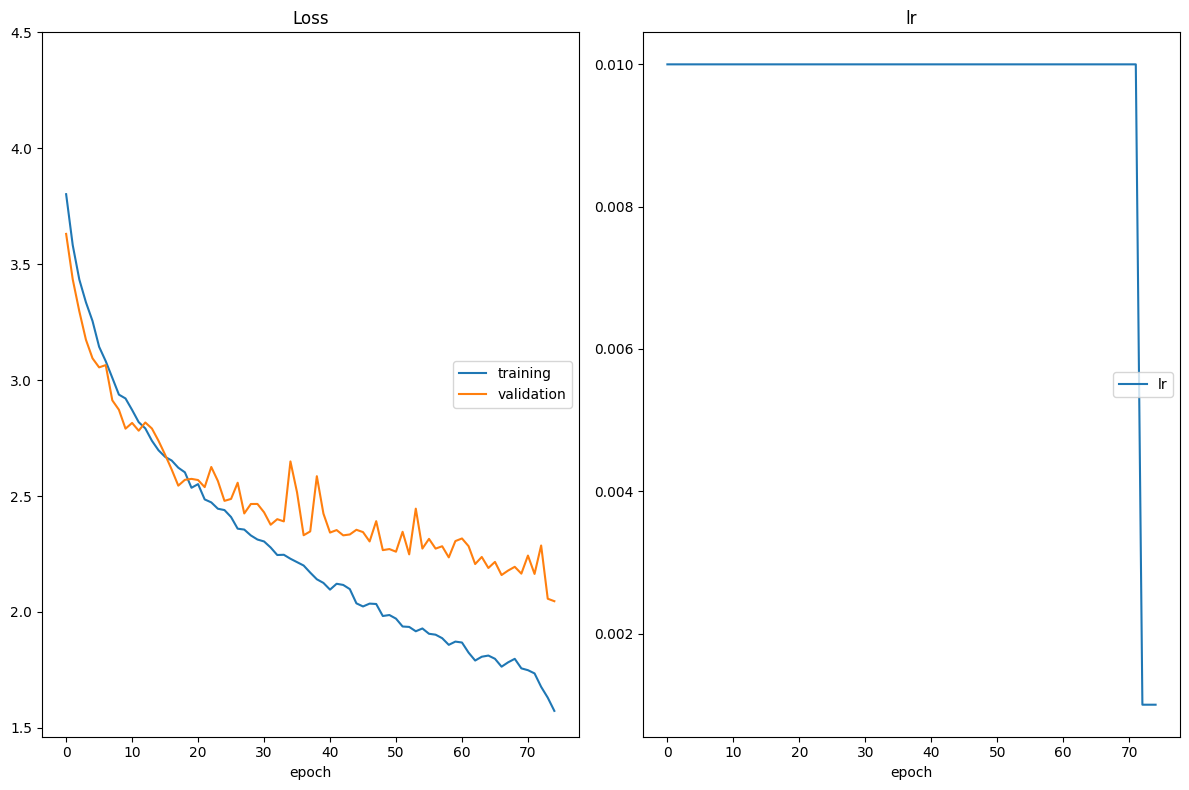

In [10]:
numEpochs = 75        # number of epochs for training
dropout = 0.5          # dropout for our model
lr = 1e-2  # Learning rate for SGD (or Adam)
opt = 'sgd'            # optimizer. 'sgd' or 'adam'
momentum = 0.9
reg = 1e-3    # regularization. Increase this to combat overfitting

# get the data loaders using batch_size and valid_size defined in the previous cell
#dataLoaders = get_data_loaders(batch_size=batchSize, valid_size=validSize, num_workers=4)

if net is None:
    net = CNNet(numClasses=numClasses, dropout=0.5, imgSize=numPixels)

# Get the optimizer using get_optimizer and the model you just created, the learning rate,
# the optimizer and the weight decay specified in the previous cell
optimizer = get_optimizer(model=net, optimizer=opt, learning_rate=lr, weight_decay=reg)

# Get the loss using get_loss
loss = get_loss()

bestPath = "checkpoints/best_val_loss.pt"

optimize(
    dataLoaders,
    model=net, 
    optimizer=optimizer,
    loss=loss,
    n_epochs=numEpochs,
    save_path=bestPath,
    interactive_tracking=True,
    train_on_gpu=train_on_gpu
)

Load the optimized weights from training from the .pt file that was saved during training.
Test our model against a test dataset to get our test accuracy.

In [11]:
# load the model that got the best validation accuracy

# Load the weights in 'checkpoints/best_val_loss.pt'
net.load_state_dict(torch.load(bestPath))

# Run test
one_epoch_test(dataLoaders['test'], net, loss)

Testing: 100%|██████████████████████████████████| 20/20 [00:03<00:00,  6.62it/s]

Test Loss: 1.846850


Test Accuracy: 52% (659/1250)


1.8468497395515444

Test our model again to predict class labels for a new set of images that we load in a separate dataloader instance with a batch size of 1. We export our model using our Predictor class.

In [12]:
dataLoaders = get_data_loaders(batch_size=1)

# First let's get the class names from our data loaders
classNames = dataLoaders["train"].dataset.classes

# Then let's move the model_transfer to the CPU (we don't need GPU for inference)
net = CNNet(numClasses=numClasses, dropout=0.5).cpu()

# Let's make sure we use the right weights by loading the
# best weights we have found during training
# NOTE: remember to use map_location='cpu' so the weights
# are loaded on the CPU (and not the GPU)

net.load_state_dict(torch.load(bestPath, map_location=torch.device('cpu')))

# Let's wrap our model using the predictor class
mean, std = compute_mean_and_std()
predictor = Predictor(net, classNames, mean, std).cpu()

predictPath = "checkpoints/predicted_model_exported.pt"

# Export using torch.jit.script
scripted_predictor = torch.jit.script(predictor)

scripted_predictor.save(predictPath)

Reusing cached mean and std
Dataset mean: tensor([0.4638, 0.4725, 0.4687]), std: tensor([0.2697, 0.2706, 0.3017])
Reusing cached mean and std


Make sure the exported model has the same performance as the original one, by reloading it and testing it. The Predictor class takes different inputs than the non-wrapped model, so we have to use a specific test loop.

100%|███████████████████████████████████████| 1250/1250 [00:36<00:00, 34.30it/s]


Accuracy: 0.512


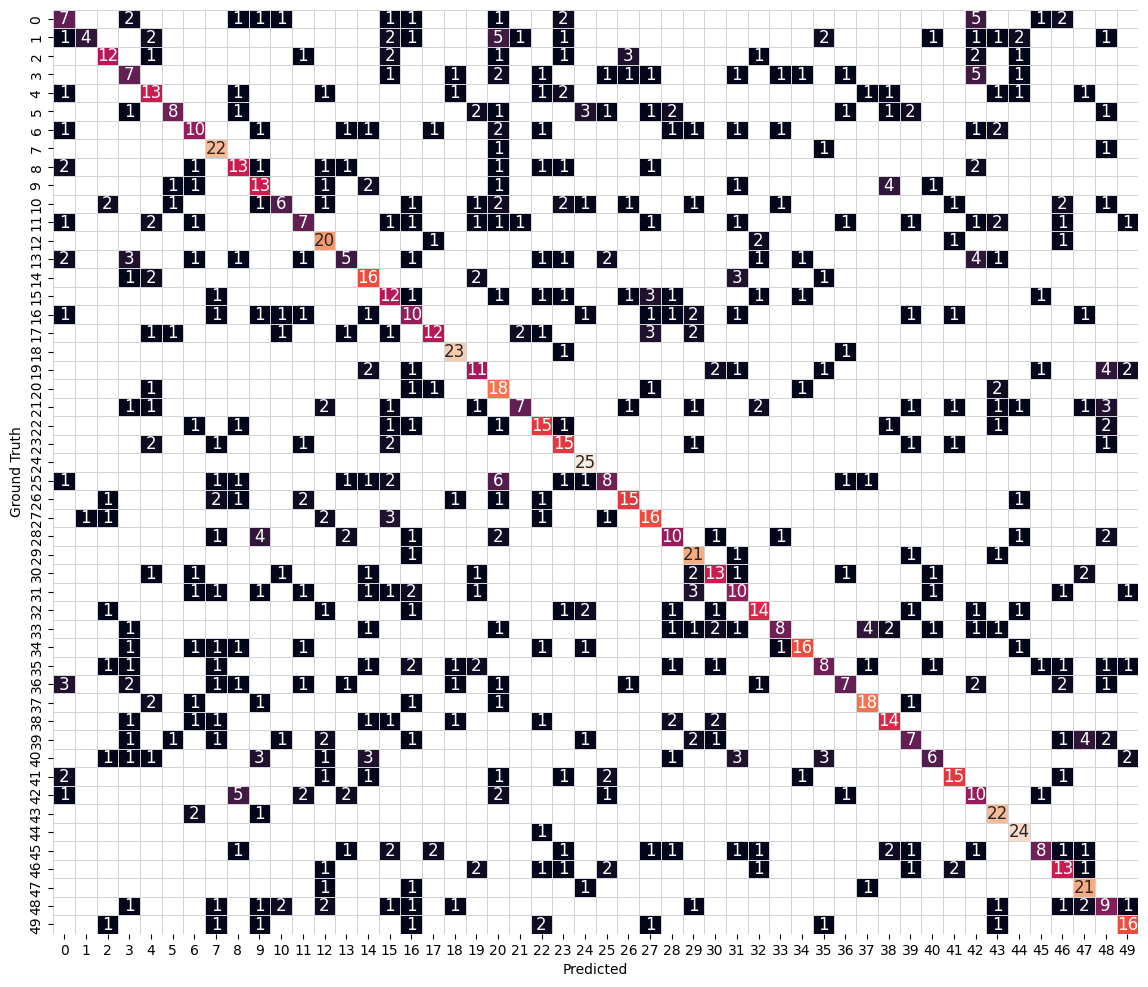

In [13]:
# make sure the exported model has the same performance as the original one, by reloading it and testing it. 
# The Predictor class takes different inputs than the non-wrapped model, so we have to use a specific test loop

# Load using torch.jit.load
netReloaded = torch.jit.load(predictPath)

pred, truth = predictor_test(dataLoaders['test'], netReloaded)

plot_confusion_matrix(pred, truth)